# Analysis of SARS-COV-2 virus neutalization in different Ace2 clones

### Set up Analysis

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [6]:
sample_information = (pd.read_csv(config['sample_information'])
                      .drop_duplicates()
                     )

frac_infect = list() # create df list

for f in config['depletion_neuts'].keys():
    df = (pd.read_csv(f, index_col=0).assign(cells=config['depletion_neuts'][f]))
    df = df.merge(sample_information, on='serum')
    frac_infect.append(df)  
    

In [7]:
for df in frac_infect:
    df['serum'] = df['serum'] + '__' + df['cells']

In [8]:
sample_information

,day,age,vaccine,subject_name,serum,gender
0,9,18-55y,Pfizer,192C,192C-day-9,Female
1,8,18-55y,Pfizer,194C,194C-day-8,Male
2,10,18-55y,Pfizer,63C,63C-day-10,Female
3,15,>55y,Pfizer,64C,64C-day-15,Female
4,27,18-55y,Pfizer,99C,99C-day-27,Male
5,18,>55y,Pfizer,108C,108C-day-18,Female


## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [9]:
frac_infect_combined = list()

for cells in frac_infect:
    fits = neutcurve.CurveFits(cells, fixbottom= False)
    frac_infect_combined.append(fits)

In [10]:
fitparams_combined = pd.DataFrame() # create empty data frame

for fits in frac_infect_combined:
    fitparams = (
        fits.fitParams()
        .rename(columns={'virus': 'depletion'})
        # get columns of interest
        [['serum', 'depletion', 'ic50', 'ic50_bound']]
        .assign(NT50=lambda x: 1/x['ic50'])
#         .merge(sample_information, on=['serum'])
        
        )
    fitparams_combined = fitparams_combined.append(fitparams).reset_index(drop=True)
    

fitparams_combined['ic50_is_bound'] = fitparams_combined['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

fitparams_combined
fitparams_combined.to_csv(config['neuts'], index=False)


In [11]:
fitparams_combined

,serum,depletion,ic50,ic50_bound,NT50,ic50_is_bound
0,63C-day-10__very_low_ACE2,pre-depletion,0.000031,interpolated,31968.943613,False
1,63C-day-10__very_low_ACE2,post-depletion,0.000454,interpolated,2200.799322,False
2,64C-day-15__very_low_ACE2,pre-depletion,0.000064,interpolated,15594.993852,False
3,64C-day-15__very_low_ACE2,post-depletion,0.000199,interpolated,5029.538042,False
4,99C-day-27__very_low_ACE2,pre-depletion,0.000096,interpolated,10374.149491,False
5,99C-day-27__very_low_ACE2,post-depletion,0.000435,interpolated,2296.488086,False
6,108C-day-18__very_low_ACE2,pre-depletion,0.000038,interpolated,26336.105034,False
7,108C-day-18__very_low_ACE2,post-depletion,0.000225,interpolated,4450.299723,False
8,63C-day-10__low_ACE2,pre-depletion,0.000040,interpolated,24852.475407,False
9,63C-day-10__low_ACE2,post-depletion,0.000704,interpolated,1420.647038,False


In [12]:
fitparams_combined[['sample', 'cells']] = fitparams_combined['serum'].str.split('__', 1, expand=True)


## Plot IC50 values

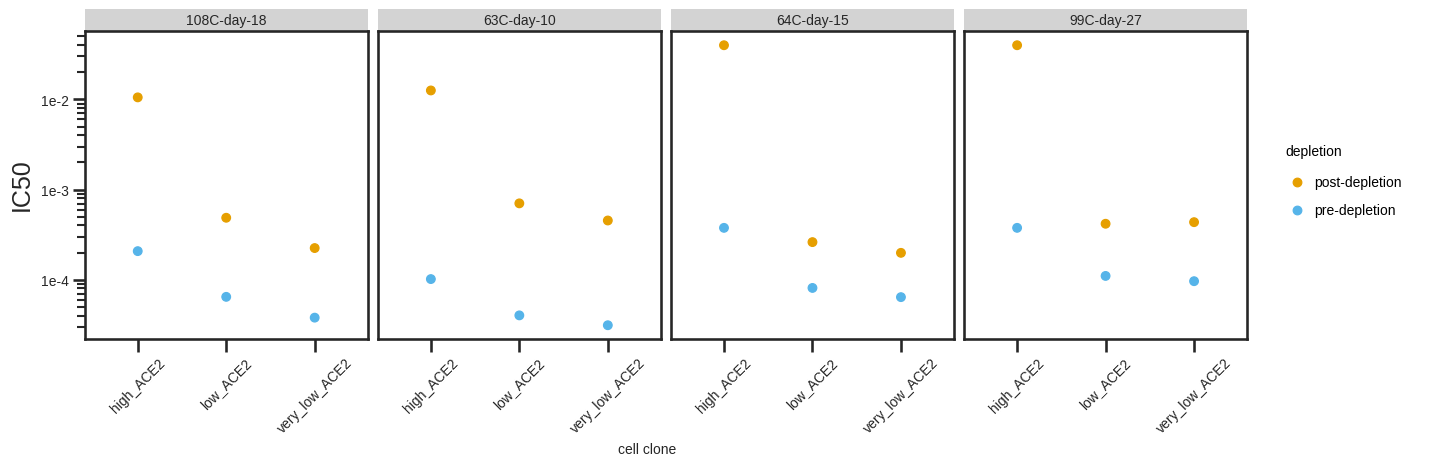

In [13]:
IC50 = (ggplot(fitparams_combined, aes(x='cells', y='ic50', colour='depletion')) +
              geom_point(size=3) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10, angle= 45),
                   legend_text=element_text(size=10),
                   legend_title=element_text(size=10),
                   axis_title_x=element_text(size=10),
                   strip_text = element_text(size=10)
                  ) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='IC50') +
              xlab('cell clone') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = IC50.draw()
# IC50.save(f'./{resultsdir}/IC50.pdf')

## Plot NT50 values

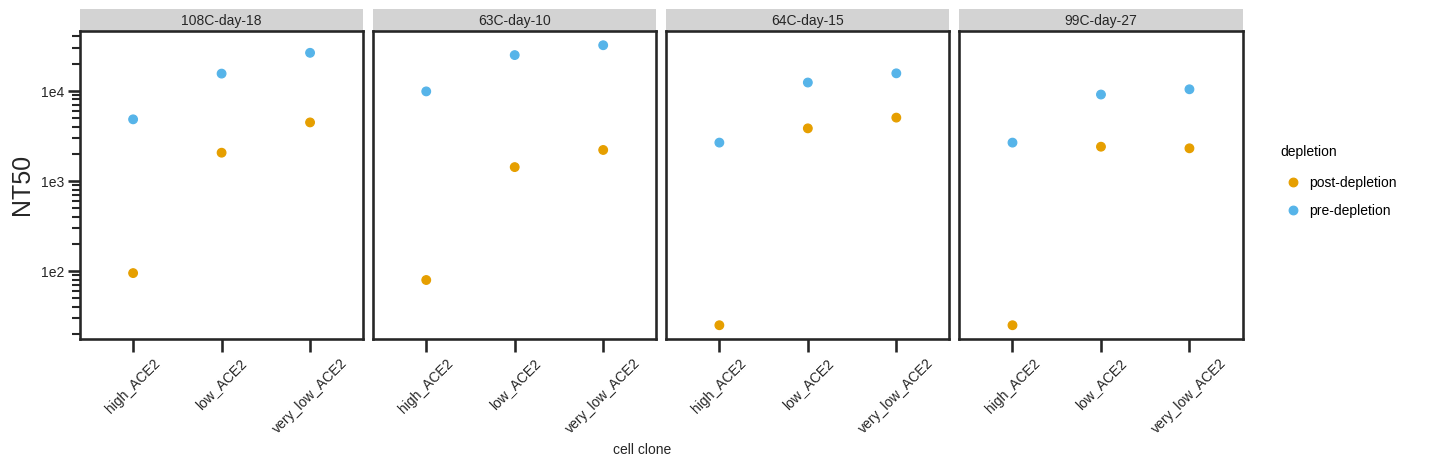

In [14]:
NT50 = (ggplot(fitparams_combined, aes(x='cells', y='NT50', colour='depletion')) +
              geom_point(size=3) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10, angle= 45),
                   legend_text=element_text(size=10),
                   legend_title=element_text(size=10),
                   axis_title_x=element_text(size=10),
                   strip_text = element_text(size=10)
                  ) +
              facet_wrap('sample', ncol = 4)+
              scale_y_log10(name='NT50') +
              xlab('cell clone') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = NT50.draw()
# NT50.save(f'./{resultsdir}/IC50.pdf')


## IC50 fold change

In [15]:
df_pre = fitparams_combined.loc[fitparams_combined['depletion'] == 'pre-depletion']
df_post = fitparams_combined.loc[fitparams_combined['depletion'] == 'post-depletion']
df_mege = pd.merge(df_pre, df_post, on="serum")
df_mege['IC50_fold_change'] = df_mege['ic50_x']/df_mege['ic50_y']

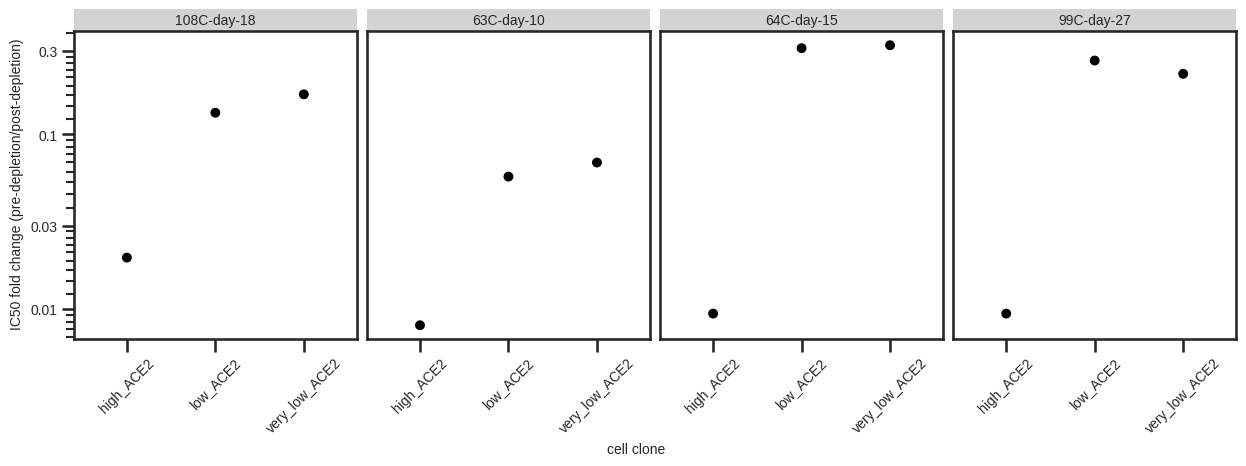

In [16]:
IC50_fc = (ggplot(df_mege, aes(x='cells_y', y='IC50_fold_change')) +
              geom_point(size=3) +
             theme(figure_size=(15,1*df['serum'].nunique()),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10, angle= 45),
                   legend_text=element_text(size=10),
                   legend_title=element_text(size=10),
                   axis_title_x=element_text(size=10),
                   axis_title_y=element_text(size=10),
                   strip_text = element_text(size=10)
                  ) +
              facet_wrap('sample_y', ncol = 4)+
              scale_y_log10(name='IC50 fold change (pre-depletion/post-depletion)') +
              xlab('cell clone') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = IC50_fc.draw()
# IC50.save(f'./{resultsdir}/IC50.pdf')

## Make horizontal line plot connecting pre- and post-IC50

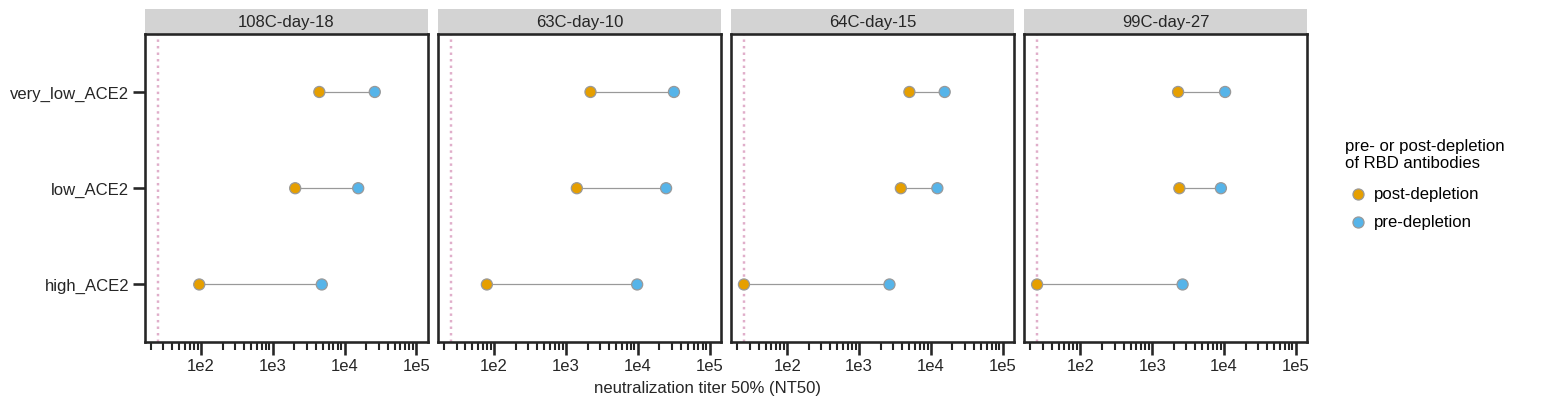

In [17]:
p = (ggplot(fitparams_combined, 
            aes(x='NT50',
                y='cells',
                fill='depletion',
                group='cells',
               )) +
     scale_x_log10(name='neutralization titer 50% (NT50)', 
                   limits=[config['NT50_LOD'],fitparams_combined['NT50'].max()*3]) +
     geom_vline(xintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
     geom_line(alpha=1, color=CBPALETTE[0]) +
     geom_point(size=4, color=CBPALETTE[0]) +
     theme(figure_size=(15,1*df['serum'].nunique()),
           axis_text=element_text(size=12),
           legend_text=element_text(size=12),
           legend_title=element_text(size=12),
           axis_title_x=element_text(size=12),
           strip_text = element_text(size=12)
          ) +
     facet_wrap('sample', ncol = 4) +
     ylab('') +
    scale_fill_manual(values=['#E69F00', '#56B4E9', ], 
                     name='pre- or post-depletion\nof RBD antibodies')
    )

_ = p.draw()


## Plot neut curves for all samples

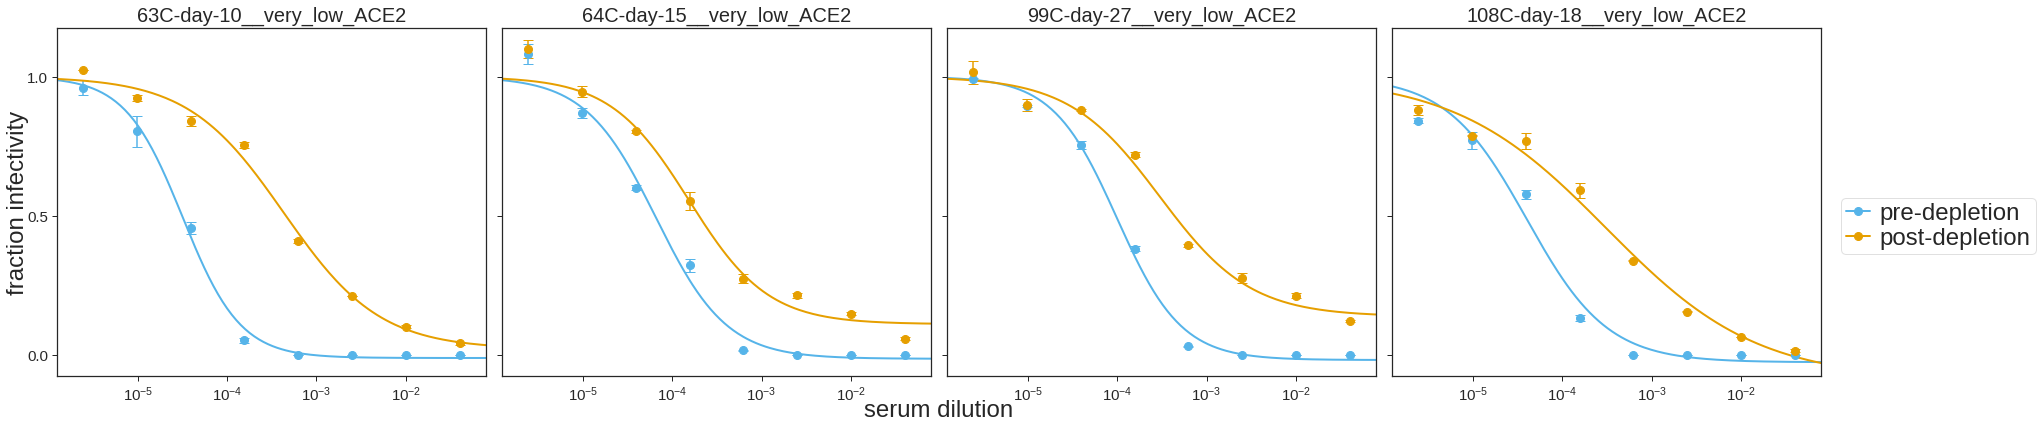

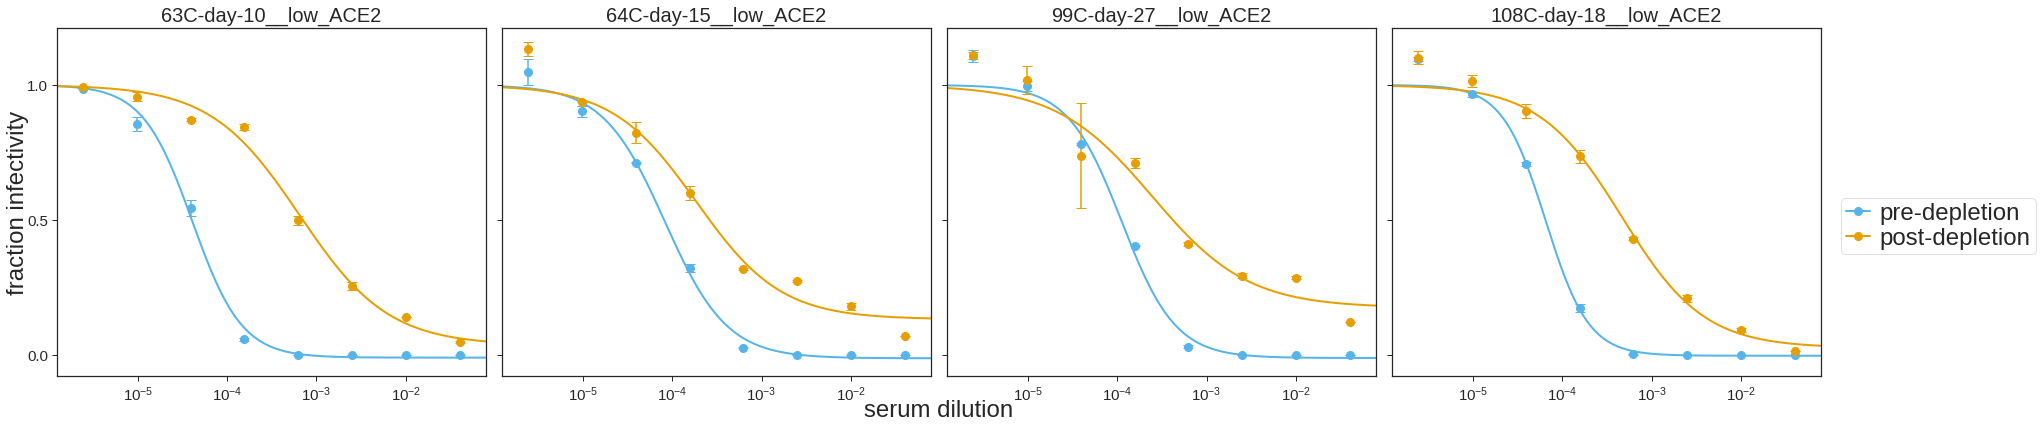

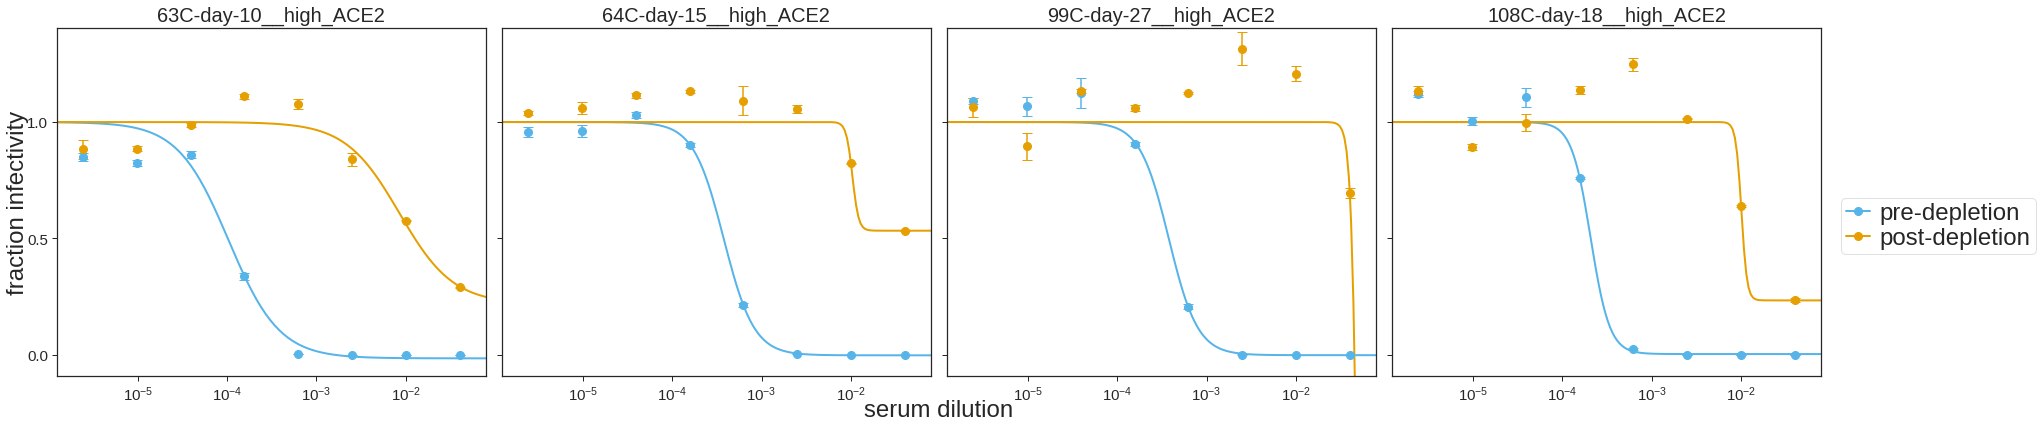

In [18]:
for fits in frac_infect_combined:
    fig, axes = fits.plotSera(
                              xlabel='serum dilution',
                              ncol=4,
                              widthscale=2,
                              heightscale=2,
                              titlesize=20, labelsize=24, ticksize=15, legendfontsize=24, yticklocs=[0,0.5,1],
                              markersize=8, linewidth=2,
                              virus_to_color_marker={
                              'pre-depletion': ('#56B4E9', 'o'),
                              'post-depletion': ('#E69F00', 'o')}
                             )